In [1]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np


from network import DDPM, ContextUnet, ContextUnetColored
from dataset import add_hue_confounded

In [2]:
n_T = 400 # 500
device = "cuda:7" if torch.cuda.is_available() else "cpu"
batch_size = 1
n_classes = 10
n_feat = 48 # 128 ok, 256 better (but slower)
save_model = False
cond_mode = "Attention"
# save_dir = './data/diffusion_outputs10/'
ws_test = [0.0, 0.5, 2.0] # strength of generative guidance

ddpm = DDPM(nn_model=ContextUnetColored(in_channels=3, n_feat=n_feat, n_classes=n_classes, cond_mode=cond_mode), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1, color=True)
ddpm.to(device)

# optionally load a model
ddpm.load_state_dict(torch.load("./experiments/240507_1/model/model_20.pth", map_location=device))

tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

dataset = MNIST("./data", train=True, download=True, transform=tf)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)

testset = MNIST("./data", train=False, download=True, transform=tf)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=5)
ddpm.eval()

DDPM(
  (nn_model): ContextUnetColored(
    (init_conv): ResidualConvBlock(
      (conv1): Sequential(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (conv2): Sequential(
        (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
    )
    (down1): UnetDownAttention(
      (res): ResidualConvBlock(
        (conv1): Sequential(
          (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GELU(approximate='none')
        )
        (conv2): Sequential(
          (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [5]:
results = ddpm.sample(10, (3,28,28),device,2)
results = results[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


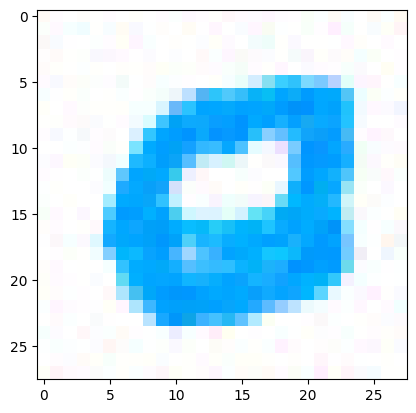

In [6]:
plt.imshow((-1 * results[0].detach().cpu() + 1).permute(1,2,0))

In [7]:
true_hues = 0.0
true_hues = torch.tensor([true_hues+0.05]).to(device)
u = ddpm.abduct(results[0], \
                torch.tensor([0], dtype=torch.int64).to(device),\
                size=(3,28,28), device=device, guide_w=1, hues=true_hues)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   1.,   0.,   0.,   0.,   3.,   3.,   2.,   3.,   1.,
          6.,   2.,   7.,   8.,  10.,   6.,  11.,  10.,  24.,  16.,  19.,
         18.,  20.,  25.,  31.,  34.,  35.,  45.,  33.,  39.,  45.,  48.,
         54.,  69.,  57.,  79.,  66.,  68.,  67., 107.,  78.,  74.,  66.,
         68.,  53.,  57.,  84.,  76.,  59.,  67.,  68.,  65.,  52.,  58.,
         46.,  40.,  30.,  20.,  21.,  27.,  23.,  24.,  25.,  19.,  13.,
         11.,   4.,   6.,   8.,  11.,   5.,   5.,   5.,   1.,   2.,   0.,
          2.,   0.,   2.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-4.18710041, -4.10854959, -4.0299983 , -3.95144749, -3.87289643,
        -3.79434538, -3.71579432, -3.63724327, -3.55869222, -3.4801414 ,
        -3.40159035, -3.32303929, -3.24448824, -3.16593719, -3.08738637,
        -3.00883532, -2.93028426, -2.85173321, -2.77318215, -2.6946311 ,
        -2.61608028, -2.53

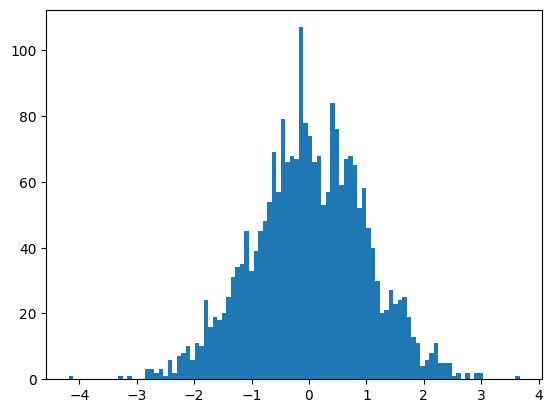

In [6]:
# plot histogram of u[0] pixel values
plt.hist(u[0].detach().cpu().numpy().flatten(), bins=100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


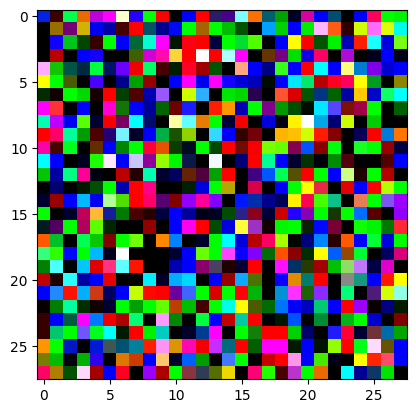

In [6]:
plt.imshow(u[0].permute(1,2,0).detach().cpu().numpy())

In [ ]:
u_random = torch.randn_like(u)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


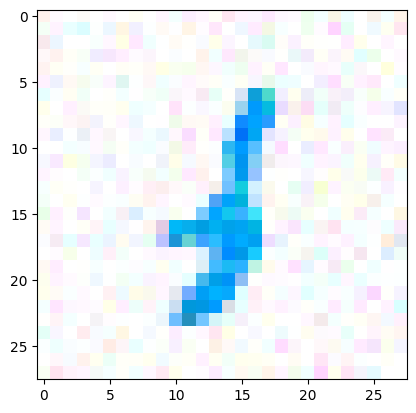

In [16]:
x_cf = ddpm.reconstruct(u, \
                        torch.tensor([6], dtype=torch.int64, device=device),\
                        size=(3,28,28), device=device, guide_w=1, \
                        hues=torch.tensor([0.05],device=device))
plt.imshow((-1*x_cf[0]+1).permute(1,2,0).detach().cpu().numpy())

In [17]:
tmpdata=torch.load('./classifiedMNIST/model0.01_10/batch_0.pth')

In [20]:
for i in tmpdata:
    print(i.shape)

torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128])
torch.Size([128, 10])
torch.Size([128])


In [ ]:
n_T = 400 # 500
device = "cuda:7" if torch.cuda.is_available() else "cpu"
batch_size = 1
n_classes = 10
n_feat = 256 # 128 ok, 256 better (but slower)
save_model = False
# save_dir = './data/diffusion_outputs10/'
ws_test = [0.0, 0.5, 2.0] # strength of generative guidance

ddpm_base = DDPM(nn_model=ContextUnet(in_channels=3, n_feat=n_feat, n_classes=n_classes), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
ddpm_base.to(device)

# optionally load a model
ddpm_base.load_state_dict(torch.load("./experiments/240503_3/model/model_10.pth", map_location=device))

ddpm_base.eval()

In [ ]:
results = ddpm.sample(10, (3,28,28),device,1)
results = results[0]
plt.imshow((-1 * results[1].detach().cpu() + 1).permute(1,2,0))

In [ ]:

u_base = ddpm_base.abduct(results[1], torch.tensor([1], dtype=torch.int64).to(device), size=(3,28,28), device=device, guide_w=1)

In [ ]:
x_cf_base = ddpm_base.reconstruct(u, \
                        torch.tensor([5], dtype=torch.int64, device=device),\
                        size=(3,28,28), device=device, guide_w=1)
plt.imshow((-1*x_cf_base[0]+1).permute(1,2,0).detach().cpu().numpy())

In [ ]:
# use plt.imshow to show one sample
image = results[0][0].clone().cpu().detach().numpy()
image.shape

In [ ]:
# image.shape is (1,28,28) grey scale. How to imshow it?
plt.imshow(image[0], cmap='gray')